#  Multinomial Logistic Regression (Softmax Classifier)
----

We introduced logistic regression for performing binary classificasion in the previous section.

Binary classificasion is quite useful and can be used for categorizing sentiment such positive or negative But not every 
classification problem fits the mold of binary classificasion for instance we might be interested in 3-way sentiment classification (positive, negative, or neutral) which involves more than two categories for which we will refer to these categories as N number of categories. There are several methods for dealing with such problem including

$\textbf{multinomial logistic regression, also called softmax multinomial logistic regression}$

$\textbf{The multinomial logistic classifier uses a generalization of the sigmoid function called the softmax function}$ to handle multi-class classification problems. where $y_{i}=1, 2,---,N$ with N being the number of classes. It takes N-dimensional vector of arbitrary real values and produces another N-dimensional vector with real values.


Given an input vector $O$, softmax first exponentiates (ensuring non-negativity)  $e^{O_{i}}$, forcing all values to be strictly positive then normalizes it by $\sum_{j}exp(O_{j})$ so that all predicted values for an input sum to $\textbf{1}$. 
Given as input vector the softmax function is defined as


 $$ \hat y_{i} =spftmax(O_{i})= \frac{exp(O_{i})}{\sum_{j}exp(O_{j})}  $$
Where $O=Wx+b$



# NOTE THAT
$\textbf{the bias term is now a vector, with one component for each output node}$

Generally if we are given a minibatch X of examples with dimensionality $d$ and batch size $n$
and and have a target variable with q categories (outputs). Then
the minibatch features $X \in R^{n\times d}$, weights $W \in R^{d\times q}$, and the bias satisfies $b\in R^{q}$

Using a dataset of 3 examples and 4 features $(X \in R^{3 \times 4})$ and with 3 possible output categories, we will need 12 scalars to represent the weights, ($ w \in R^{4 \times 3}$) and 3 scalars to represent the biases ($b \in R^{3}$).
We compute these three logits, $O_{1}, O_{2},$ and $O_{3}$, for each input:


$$O_{1} =w_{11}x_{1} + w_{12}x_{2}+w_{13}x_{3}+w_{14}x_{4} +b_{1}     $$
$$O_{2} =w_{21}x_{1} + w_{22}x_{2}+w_{23}x_{3}+w_{24}x_{4} +b_{2}     $$
$$O_{3} =w_{31}x_{1} + w_{32}x_{2}+w_{33}x_{3}+w_{34}x_{4} +b_{3}     $$

Using softmax function defined above the outputs for the $O_{i}$ will be

$OUTPUT(O_{1})=\frac{\exp(O_{1})}{\exp(O_{1} ) + \exp(O_{2}) +\exp(O_{3})},   OUTPUT(O_{2})=\frac{\exp(O_{2})}{\exp(O_{1} )+\exp(O_{2})   +     \exp(O_{3})},  OUTPUT(O_{3})=\frac{\exp(O_{3})}{\exp(O_{1} )+\exp(O_{2}) +\exp(O_{3})}$


and with the predicted class being the class with the highest probability
  $$predicted \ class=argmax_{i} \hat y(O_{i}) $$
  
  the softmax classifier output values within the range $[0, 1]$. the denominator normalizes the values which causes these class probabilities to sum up to one

In [1]:
import d2l
import mxnet as mx
from mxnet import nd,npx,np, autograd, gluon
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mx.random.seed(42)

In [3]:
def softmax(x):
    numerator=np.exp(x)
    denominator=numerator.sum(axis=1,keepdims=True)
    return numerator/denominator
    

In [4]:
x=np.array([[ 0.0450, -0.0506,  1.2059],
        [ 0.4869, -2.0537,  0.5696]])
x

array([[ 0.045 , -0.0506,  1.2059],
       [ 0.4869, -2.0537,  0.5696]])

In [5]:
softmax(x)

array([[0.19601569, 0.17814443, 0.6258399 ],
       [0.46188632, 0.03640546, 0.50170827]])

In [6]:
np.sum(softmax(x),axis=1)

array([1., 1.])

# Categorical cross-entropy loss (also referred to as negative loglikelihood)

The categorical cross entropy loss is used for multiclass classification task which measures the dissimilarity between the predicted label distribution$\hat y$ and the true label distribution $y$ and is defined as

$$  \ell(y_{i}, \hat y_{i})=\sum^{n}_{i=1}-y_{i}log \hat y_{i} $$




# MULTICLASS LOGISTIC REGRESSION (SOFTMAX)  FROM SCRATCH

In [7]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import d2l
import matplotlib.pyplot as plt
mx.random.seed(1)

In [8]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### We are going to load the data and transform both the inputs and labels to float32 array. Since the input data has values between 0-255 we will divide each value by 255 to have values between 0 and 1

In [9]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=True,transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False,transform=transform)

### a function to visualize examples of the data

In [10]:
def get_fashion_mnist_labels(labels):
    text_labels = ['zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine']
    return [text_labels[int(i)] for i in labels]

# Saved in the d2l package for later use
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

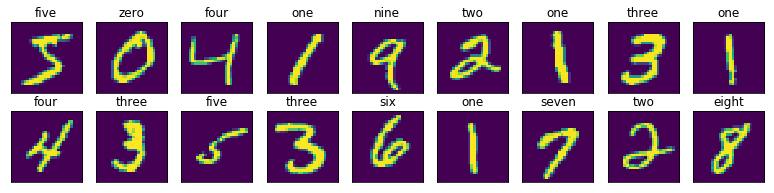

In [11]:
X, y = mnist_train[:20]
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

In [12]:
image, label = mnist_train[0]
print(image.shape,label)

(28, 28, 1) 5.0


#  data iterator

In [13]:
batch_size = 80
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)


Each example in the raw data is a $28 \times 28$ image so a sample of the images will have a shape of ($ num\_samples \times 28 \times 28$). since our model will be defined to accept an inputs of shape ($m \times n$) we will flatten the shape of our data to ($ num\_samples \times 784$) where $784=28\times 28$. Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ vector Because our dataset has $10$ categories


$$X\in R^{n \times 784}, W\in R^{784 \times 10} b\in R^{1 \times 10} $$

In [14]:
num_inputs = 784
num_outputs = 10
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=model_ctx)
b = nd.random_normal(shape=num_outputs,ctx=model_ctx)
params = [W, b]

### we will be updating our model parameters using gradient descent so we need to $\textbf{attached gradients}$ to  the parameters


In [15]:
for param in params:
    param.attach_grad()

## defining the softmax model

In [16]:
def softmax(X):
    exp = nd.exp(X)
    norms_cost = exp.sum(axis=1, keepdims=True)
    return exp / norms_cost

In [17]:
def net(X):
    y_linear = nd.dot(X, W) + b
    probs = softmax(y_linear)
    return probs

# loss function
A loss function— defines the feedback signal used for learning ( measures how well the model predictions match that of the true label)

In [18]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat))

# Optimizer
An optimizer—A mechanism to update the model parameters

 we will use minibatch stochastic gradient descent with a learning rate of 0:5 as the optimization algorithm
 
## NOTE
The learning rate is tuning parameter which determines how big a step is taking along the gradient in order to find a better weight. A too high value will make the learning jump over the minima but smaller values slow it down and will take too long to converge

In [19]:
def SGD(params, lr,batch_size):    
    for param in params:
        param[:] = param - lr * param.grad/batch_size

# Evaluation metrics to evaluate the model

In [20]:
def evaluate_accuracy(data_iterator, net):
    pred_correct = 0.
    for i ,(data,label) in enumerate(data_iterator):
        data=data.as_in_context(model_ctx).reshape(-1,784)
        label=label.as_in_context(model_ctx)
        one_hot=nd.one_hot(label,10)
        output=net(data)
        pred=nd.argmax(output,axis=1)
        pred_correct=nd.sum(pred==label)
        return (pred_correct/len(data)).asscalar()

In [21]:
evaluate_accuracy(test_data, net)

0.0875

# Training the model

In [22]:
epochs = 20
learning_rate = .005
num_examples = len(mnist_train)
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate,batch_size=batch_size)
        cumulative_loss += nd.sum(loss).asscalar()        
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))       

Epoch 0. Loss: 9.20377909749349, Train_acc 0.2125, Test_acc 0.1875
Epoch 1. Loss: 5.388397652689616, Train_acc 0.35, Test_acc 0.35
Epoch 2. Loss: 4.014106680043539, Train_acc 0.6, Test_acc 0.4125
Epoch 3. Loss: 3.230642574310303, Train_acc 0.5, Test_acc 0.4875
Epoch 4. Loss: 2.727163686498006, Train_acc 0.5875, Test_acc 0.4875
Epoch 5. Loss: 2.3834525862375897, Train_acc 0.6, Test_acc 0.5375
Epoch 6. Loss: 2.13699893544515, Train_acc 0.6125, Test_acc 0.6
Epoch 7. Loss: 1.9522124556223552, Train_acc 0.6125, Test_acc 0.625
Epoch 8. Loss: 1.8085036061604818, Train_acc 0.7125, Test_acc 0.625
Epoch 9. Loss: 1.6929135046005248, Train_acc 0.65, Test_acc 0.65
Epoch 10. Loss: 1.5981280768076578, Train_acc 0.7375, Test_acc 0.6625
Epoch 11. Loss: 1.5187535309473674, Train_acc 0.6, Test_acc 0.675
Epoch 12. Loss: 1.4510313093821208, Train_acc 0.65, Test_acc 0.6875
Epoch 13. Loss: 1.3926135765075685, Train_acc 0.775, Test_acc 0.6875
Epoch 14. Loss: 1.3415942284266154, Train_acc 0.75, Test_acc 0.7
Ep

(10, 28, 28, 1) 

the true labels are


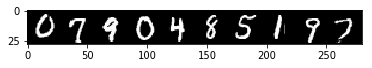

model predictions are: 
[0. 7. 9. 0. 4. 8. 5. 1. 9. 7.]
<NDArray 10 @cpu(0)>


In [23]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape,'\n')
    print('the true labels are')
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break